# In this notebook:

- Use selenium & python to automatically:
    - Log-in to GoodReads account
    - Click on the 'read' bookshelf
    - Scroll all the way down and download the entire list of books in the self
    - Save this to a CSV file
    
- Notes:
    - Make sure to toggle on 'infinite scroll' instead of a certain number of pages shown on the bottom of your books page of your GoodReads account, you only have to do this once: 
    
    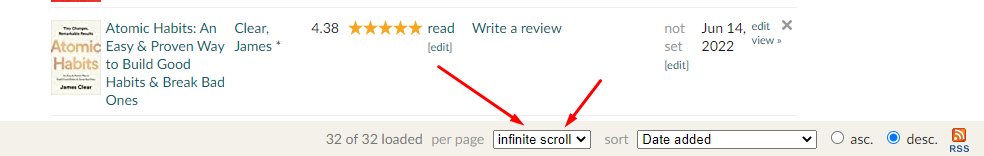

In [3]:
# Imports

import pandas as pd
import requests
import time
import getpass
from selenium import webdriver
from selenium.common.exceptions import ElementClickInterceptedException
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.wait import WebDriverWait
from webdriver_manager.chrome import ChromeDriverManager
from webdriver_auto_update import check_driver
from bs4 import BeautifulSoup

In [4]:
# Check if your chromedriver is compatible with your current version of google chrome
# Change this to the path where your chromedriver is located

check_driver(r'C:\Users\HP\Data Science\GoodReads')

Local chromedriver version: 102.0.5005.61
Latest online chromedriver version: 102.0.5005.61


True

In [34]:
def scrape_goodreads2(email, password):
    # Setting up info 
    e_mail = email
    pass_word = password
    url = 'https://www.goodreads.com'
    
    # Open Chrome Window
    s = Service("chromedriver.exe")
    browser = webdriver.Chrome(service=s)
    browser.maximize_window()
    browser.get(url)
    
    # Log-in
    try:
        browser.find_element(By.CSS_SELECTOR, '#signIn > div > div > a').click()
        browser.find_element(By.CSS_SELECTOR, '#choices > div > a:nth-child(4) > button').click()
        browser.find_element(By.CSS_SELECTOR, '#ap_email').send_keys(e_mail)
        browser.find_element(By.CSS_SELECTOR, '#ap_password').send_keys(pass_word)
        browser.find_element(By.CSS_SELECTOR, '#signInSubmit').click()
    except Exception:
        pass
    
    # Go to 'books' page
    try:
        books = browser.find_element(By.CSS_SELECTOR, 'body > div.siteHeader > div > header > div.headroom-wrapper > div > nav > ul > li:nth-child(2) > a')
        browser.execute_script('arguments[0].click();', books) 
        browser.find_element(By.CSS_SELECTOR, '#paginatedShelfList > div:nth-child(1) > a').click()
        browser.find_element(By.CSS_SELECTOR, '#booksHeader > th.header.field.rating > a > nobr').click()
    except Exception:
        pass
    
    # Scroll all the way down
    scroll_pause_time = 1 # You can set your own pause time. My laptop is a bit slow so I use 1 sec
    screen_height = browser.execute_script("return window.screen.height;")   # get the screen height of the web
    i = 1
    while True:
        # scroll one screen height each time
        browser.execute_script("window.scrollTo(0, {screen_height}*{i});".format(screen_height=screen_height, i=i))  
        i += 1
        time.sleep(scroll_pause_time)
        # update scroll height each time after scrolled, as the scroll height can change after we scrolled the page
        scroll_height = browser.execute_script("return document.body.scrollHeight;")  
        # Break the loop when the height we need to scroll to is larger than the total scroll height
        if (screen_height) * i > scroll_height:
            break

    current_url = browser.current_url

    # Scrape the data and put it in a table
    soup = BeautifulSoup(browser.page_source)
    
    table = soup.find("table", {"class": "table stacked"})
    headers = []
    for i in table.find_all('th'):
        title = i.text
        headers.append(title)
    
    # Save the table to a dataframe
    mydata = pd.DataFrame(columns = headers)
        
    for j in table.find_all('tr')[1:]:
     row_data = j.find_all('td')
     row = [i.text for i in row_data]
     length = len(mydata)
     mydata.loc[length] = row 

    # Prettify the table 
    columns_i_want = [3, 4, 8, 9, 10, 11, 13, 22]
    new_table = mydata.iloc[:, columns_i_want]
    new_table.columns = new_table.columns.str.replace('\n', '')
    new_table.columns = new_table.columns.str.strip()
    new_table = new_table.replace('\n', '', regex=True)
    new_table['title'] = new_table['title'].str.replace('title ', '', regex=True)
    new_table['author'] = new_table['author'].str.replace('author ', '', regex=True)
    new_table['date pub'] = new_table['date pub'].str.replace('date pub ', '', regex=True)
    new_table['num pages'] = new_table['num pages'].str.replace('num pages ', '', regex=True)
    new_table['num pages'] = new_table['num pages'].str.replace(' pp', '', regex=True)
    new_table['avg rating'] = new_table['avg rating'].str.replace('avg rating', '', regex=True)
    new_table['num ratings'] = new_table['num ratings'].str.replace('num ratings ', '', regex=True)
    try:
        new_table['date read'] = new_table['date                        read'].str.replace('date read', '', regex=True)
    except KeyError:
        pass
    new_table['date read'] = new_table['date read'].str.replace('[edit]', '', regex=True)
    new_table['date read'] = new_table['date read'].str.replace('[edit]', '', regex=True)
    new_table['date read'] = new_table['date read'].str.replace('no s\[]', '-', regex=True)
    new_table['date read'] = new_table['date read'].str.replace('\[]', '', regex=True)
    new_table['date read'] = new_table['date read'].str.replace('a ra', '')
    try:
        del new_table['date                        read']
    except KeyError:
        pass
    new_table['rating'] = new_table['rating'].str.replace('my rating1 of 5 stars2 of 5 stars3 of 5 stars4 of 5 stars\[ ', '', regex=True)
    new_table['rating'] = new_table['rating'].str.replace(' of 5 stars \]', '', regex=True)
    new_table['rating'] = new_table['rating'].str.replace('my rating1 of 5 stars2 of 5 stars3 of 5 stars4 of 5 stars5 of 5 stars', 'Not Rated', regex=True)
    new_table['rating'] = new_table['rating'].str.replace('my rating1 of 5 stars2 of 5 stars3 of 5 stars\[ 45 of 5 stars', '4', regex=True)
    new_table['rating'] = new_table['rating'].str.replace('my rating1 of 5 stars2 of 5 stars\[ 34 of 5 stars5 of 5 stars', '3', regex=True)
    new_table['rating'] = new_table['rating'].str.replace('my rating1 of 5 stars\[ 23 of 5 stars4 of 5 stars5 of 5 stars', '2', regex=True)
    
    # Save the table to a csv file
    new_table.to_csv('books.csv')

In [37]:
# To demonstrate the script I have registered a new goodreads account with the following e-mail and password.
# If you want to use this script for yourself, 
# simply change the email and password to those corresponding to your GoodReads account

scrape_goodreads2(email = 'max_vander_werf@hotmail.com', password = 'Uithaal96')
# scrape_goodreads2(email = 'goodreads.scraper@gmail.com', password = 'GR_Scraper2022')



In [36]:
data = pd.read_csv('books.csv')

data

,Unnamed: 0,title,author,num pages,avg rating,num ratings,date pub,rating,date read
0,0,Grit: The Power of Passion and Perseverance,"Duckworth, Angela*",277,4.08,"97,847","May 03, 2016",4,"Apr 13, 2021"
1,1,Talking to Strangers: What We Should Kno...,"Gladwell, Malcolm",388,4.02,"234,565","Sep 10, 2019",3,"Mar 12, 2019"
2,2,The Subtle Art of Not Giving a F*ck: A C...,"Manson, Mark*",212,3.91,"791,613","Sep 13, 2016",2,"Fb 19, 2021"
3,3,The Righteous Mind: Why Good People Are ...,"Haidt, Jonathan",419,4.21,"46,162","Mar 13, 2012",5,-
4,4,Maybe You Should Talk to Someone: A Ther...,"Gottlieb, Lori*",415,4.38,"223,171","Apr 02, 2019",3,-
5,5,Outliers: The Story of Success,"Gladwell, Malcolm",309,4.18,"679,830","Nov 18, 2008",3,-
6,6,Man's Search for Meaning,"Frankl, Viktor E.",165,4.36,"548,204",1946,5,"Fb 03, 2021-"
7,7,Blink: The Power of Thinking Without Thi...,"Gladwell, Malcolm",296,3.95,"547,168","Jan 11, 2005",5,-
8,8,Fooled by Randomness: The Hidden Role of...,"Taleb, Nassim Nicholas*",368,4.08,"57,266",2001,5,-
9,9,Deep Work: Rules for Focused Success in ...,"Newport, Cal",296,4.19,"115,972","Jan 05, 2016",5,-
